In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ddm import Model, Sample
from ddm import Model
from ddm.models import DriftConstant, NoiseConstant, BoundConstant, OverlayNonDecision, ICRange
from ddm.functions import fit_adjust_model, display_model
from ddm import Fittable
from ddm.models import LossRobustBIC, LossRobustLikelihood, LossSquaredError
from ddm.functions import fit_adjust_model, fit_model
import seaborn as sns
import pickle
import scipy.io
import statsmodels.api as sm
import statsmodels.formula.api as smf


In [41]:
df_errors = pd.read_csv('Curvature_Errors.csv')
def fit_ddm_participant(participant):
    incorrect_thresold = np.array([9/90, 15/90, 20/90, 30/90, 45/90])
    model_fits_4param = np.zeros((12, len(incorrect_thresold)), dtype = object)
    for block in range(12):
        print("Participant: ", participant)
        print("Block: ", block)
        for ic in range(len(incorrect_thresold)):
            df_rt = pd.read_csv('RTs.csv')            
            df_rt['Correct'] = df_errors['Errors'] < incorrect_thresold[ic]            
            df_rt = df_rt[df_rt['Participant_Id'] == participant]
            df_rt = df_rt[df_rt["ITs"] > .001]
            df_rt = df_rt[df_rt["ITs"] < 5]
            df_rt = df_rt.drop(['Trial', 'Unnamed: 0', 'Participant_Id', 'Rotation', 'Emphasis', 'MTs'], axis = 1)

            samp = Sample.from_pandas_dataframe(df_rt[df_rt['Block'] == block], rt_column_name="ITs", correct_column_name="Correct")
            model_fit = Model(name='Simple model (fitted)',
                          drift=DriftConstant(drift=Fittable(minval=-20, maxval=20)),
                          noise=NoiseConstant(noise=Fittable(minval = 0, maxval = 5)),                      
                          bound=BoundConstant(B=Fittable(minval = 0, maxval = 20)),
                          overlay=OverlayNonDecision(nondectime=Fittable(minval = 0, maxval = 1)),
                          dx=.001, dt=.01, T_dur=5)

            try:
                fit_adjust_model(samp, model_fit,
                             fitting_method="differential_evolution",
                             lossfunction=LossRobustLikelihood, verbose=False)
            except:
                print ("In except: ")
                print (participant, block)
            model_fits_4param[participant][block][ic] = model_fit
    return model_fits_4param

# Analyzing 4 param ddm models

In [2]:
ddm_params = np.array(pickle.load(open('ddm_fits.pickle', 'rb')))


In [104]:
ddm_params[0][0][0].get_fit_result().value()

37.19494739504438

In [3]:
drift = np.zeros((60, 12, 5))
drift_noise = np.zeros((60, 12, 5))
B = np.zeros((60, 12, 5))
Ter = np.zeros((60, 12, 5))
neg_ll = np.zeros((60, 12, 5))
for participant in range(60):
    for block in range(12):
        for ic in range(5):
            drift[participant][block][ic] = ddm_params[participant][block][ic].get_model_parameters()[0].real
            drift_noise[participant][block][ic] = ddm_params[participant][block][ic].get_model_parameters()[1].real
            B[participant][block][ic] = ddm_params[participant][block][ic].get_model_parameters()[2].real
            Ter[participant][block][ic] = ddm_params[participant][block][ic].get_model_parameters()[3].real
            neg_ll[participant][block][ic] = ddm_params[participant][block][ic].get_fit_result().value()
                        

In [4]:
ddm_fits = pd.DataFrame({'Participant_no': np.repeat(np.arange(60), 12*5),
                         'Rotation': np.tile(np.repeat(np.array(['Sudden', 'Gradual']), 12*2*5), 15),
                         'Emphasis': np.tile(np.repeat(np.array(['Speed', 'Accuracy']), 12*5), 30),
                         'Incorrect_Criterion': np.tile(np.tile(np.array(['10', '15', '20', '30', '45']), 12), 60),
                         'Block':np.tile(np.repeat(np.arange(12), 5), 60), 
                         'Drift': np.ravel(drift),
                         'Drift_Noise': np.ravel(drift_noise),
                         'Boundary': np.ravel(B), 
                         'Ter': np.ravel(Ter),
                         'neg_LL': np.ravel(neg_ll)
                        })

In [107]:
ddm_fits.to_csv('ddm_fits.csv')

In [5]:
ddm_fits = pd.read_csv('ddm_fits.csv')

In [6]:
ddm_fits['Condition'] = ddm_fits['Rotation'] + '_' + ddm_fits['Emphasis']

In [9]:
ddm_fits_groups = 

,Unnamed: 0,Participant_no,Rotation,Emphasis,Incorrect_Criterion,Block,Drift,Drift_Noise,Boundary,Ter,neg_LL,Condition
0,0,0,Sudden,Speed,10,0,5.447755,4.794784,3.601203,0.316709,37.194947,Sudden_Speed
1,1,0,Sudden,Speed,15,0,6.051104,4.349996,3.566910,0.293172,29.154614,Sudden_Speed
2,2,0,Sudden,Speed,20,0,6.514686,3.736816,3.620740,0.257968,18.244875,Sudden_Speed
3,3,0,Sudden,Speed,30,0,7.865071,4.511398,4.371260,0.258198,18.244875,Sudden_Speed
4,4,0,Sudden,Speed,45,0,4.882781,2.800758,2.713759,0.250321,18.244875,Sudden_Speed
...,...,...,...,...,...,...,...,...,...,...,...,...
3595,3595,59,Gradual,Accuracy,10,11,-12.119705,4.895317,4.944461,0.450184,-11.303478,Gradual_Accuracy
3596,3596,59,Gradual,Accuracy,15,11,-11.977285,4.837791,4.886358,0.453062,-11.303478,Gradual_Accuracy
3597,3597,59,Gradual,Accuracy,20,11,-12.300736,4.968438,5.018316,0.456741,-11.303478,Gradual_Accuracy
3598,3598,59,Gradual,Accuracy,30,11,0.767198,4.805037,2.929423,0.509318,32.841486,Gradual_Accuracy


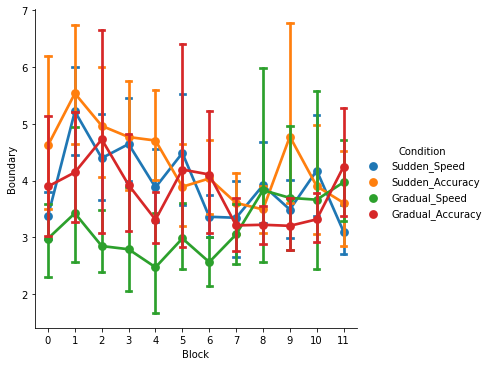

In [10]:
sns.catplot(x = 'Block', y = 'Boundary', hue = 'Condition', 
            data = ddm_fits.query("Incorrect_Criterion == '20'"), kind = 'point', capsize = 0.2)

In [33]:
model = smf.ols('Drift~C(Rotation)*C(Emphasis)', data=ddm_fits[ddm_fits['Incorrect_Criterion'] == 20][ddm_fits['Block'] == 0]).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

<ipython-input-33-b6242f747a65>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  model = smf.ols('Drift~C(Rotation)*C(Emphasis)', data=ddm_fits[ddm_fits['Incorrect_Criterion'] == 20][ddm_fits['Block'] == 0]).fit()


,sum_sq,df,F,PR(>F)
C(Rotation),1.034671,1.0,0.061427,0.805161
C(Emphasis),186.660985,1.0,11.081836,0.001546
C(Rotation):C(Emphasis),29.243702,1.0,1.736163,0.192991
Residual,943.256580,56.0,NaN,NaN


<ipython-input-32-dff394ea0ae5>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = ddm_fits[ddm_fits['Incorrect_Criterion'] == 20][ddm_fits['Block'] == 0], kind = 'bar', capsize = 0.2)


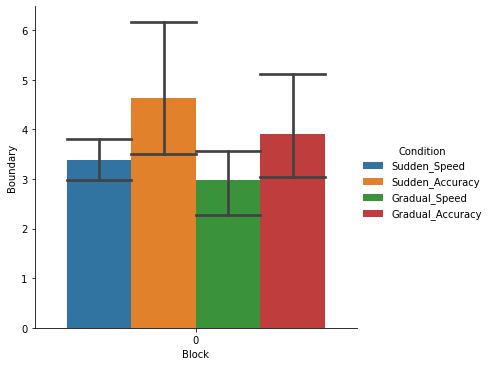

In [32]:
sns.catplot(x = 'Block', y = 'Boundary', hue = 'Condition', 
            data = ddm_fits[ddm_fits['Incorrect_Criterion'] == 20][ddm_fits['Block'] == 0], kind = 'bar', capsize = 0.2)

<ipython-input-20-24a0a088e204>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ddm_fits[ddm_fits['Incorrect_Criterion'] == 20][ddm_fits['Block'] == 10]


,Unnamed: 0,Participant_no,Rotation,Emphasis,Incorrect_Criterion,Block,Drift,Drift_Noise,Boundary,Ter,neg_LL,Condition
52,52,0,Sudden,Speed,20,10,-18.305345,4.367584,9.739016,0.003094,-26.040995,Sudden_Speed
112,112,1,Sudden,Accuracy,20,10,2.846549,4.145313,4.243547,0.209185,80.147457,Sudden_Accuracy
172,172,2,Gradual,Speed,20,10,-3.570718,2.609381,1.494600,0.378184,0.726138,Gradual_Speed
232,232,3,Gradual,Accuracy,20,10,7.706201,4.512011,2.652474,0.415840,-7.218790,Gradual_Accuracy
292,292,4,Sudden,Speed,20,10,-9.238818,4.324300,6.031629,0.227095,14.497398,Sudden_Speed
352,352,5,Sudden,Accuracy,20,10,5.520155,4.605044,3.184124,0.480329,23.186871,Sudden_Accuracy
412,412,6,Gradual,Speed,20,10,0.332781,3.097613,1.852755,0.355198,31.512514,Gradual_Speed
472,472,7,Gradual,Accuracy,20,10,6.329524,4.851175,2.884242,0.418750,9.760345,Gradual_Accuracy
532,532,8,Sudden,Speed,20,10,4.940475,4.384074,3.277556,0.454432,31.389813,Sudden_Speed
592,592,9,Sudden,Accuracy,20,10,3.718967,4.630396,3.469578,0.613356,44.465403,Sudden_Accuracy
